# Calibration Source Optimization -- N16

We are interested in knowing the probability for the gamma to be fully abosrbed.

Plots
- [ ] For each true gamma, plot the distribution of gamma energy deposits in water
- [ ] Determine the escape probability for each gamma energy

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from ROOT import TFile, AddressOf
import rat

In [69]:
plt.style.use('snoplus')
def parseMacro(macro):
    # Take the macro string and get the detector parameters
    msplit = macro.split('\n')
    print(msplit)
    
class FileParameters:
    def __init__(self, fname):
        fp = fname.replace('.root','')
        fp = fp.split('_')
        _, self.wallThickness, self.scintThickness, \
            self.scintHeight, self.canRadius, self.canHeight = fp
        
def analyze(fname):
    tfile = TFile(fname)
    params = FileParameters(fname)
    
    runT = tfile.Get("runT")
    run = rat.RAT.DS.Run()
    runT.SetBranchAddress("run", AddressOf(run))
    runT.GetEntry(0)
    pmtinfo = run.GetPMTInfo()
    
    tree = tfile.Get("T")
    ds = rat.RAT.DS.Root()
    tree.SetBranchAddress("ds", AddressOf(ds))
    
    print(tree.GetEntries())
    gamma_primaries = {}
    gamma_deposits = {}
    gamma_volumes = set()
    pe = []
    cherenkov = []

    for ent in range(tree.GetEntries()):
        tree.GetEntry(ent)
        mc = ds.GetMC()
        pe.append(mc.GetNumPE())
        ntracks = mc.GetMCTrackCount()
        npmt = mc.GetMCPMTCount()
        nScint = mc.GetMCSummary().GetNumScintPhoton()
        #print(f'Event: {ent} with {ntracks} tracks and {nScint} photons')
        cherenkov.append(mc.GetMCSummary().GetNumCerenkovPhoton())
        for track_id in range(ntracks):
            track = mc.GetMCTrack(track_id)
            parent = track.GetParentID()
            if parent != 0:
                continue
            name = track.GetParticleName()
            if name == "opticalphoton":
                continue
            ## Track gammas
            #if name == "e-":
            #    continue
            #if name == "e+":
            #    continue
            nsteps = track.GetMCTrackStepCount()
            #print(f'Mom? {track.GetParentID()}, I am {track.GetID()}')
            for step_id in range(nsteps):
                step = track.GetMCTrackStep(step_id)
                if step_id == 0:
                    start_energy = step.GetKE()
                    start_volume = step.GetVolume()
                    gamma_volumes.add(start_volume)
                    energy = start_energy
                    #print(f'    Name: {name} -- {energy} ID: {track.GetID()} {track_id} {parent} -- {track.GetLength()} {nsteps}')
                else:
                    volume = step.GetVolume()
                    if volume == "detector":
                        try:
                            gamma_deposits[start_energy].append(energy)
                        except KeyError:
                            gamma_deposits[start_energy] = [energy]
                        break
                    energy = step.GetKE()
                
        # Loop over the one pmt to get charge, check its type==3
        for ipmt in range(npmt):
            pmt = mc.GetMCPMT(ipmt)
            pmtid = pmt.GetID()
            #print(f'pmtid: {pmtid}')
        # Loop over the gamma tracks, maybe we turn off optical photons
        #print(f'npmt: {npmt}')
    return gamma_deposits, gamma_volumes, pe, cherenkov    
    
output, volumes, pe, cherenkov = analyze('calopt_5.0_2.0_50.0_55.0_155.0.root')

1000


{'sourcegas'}
dict_keys([6.13040018081665, 7.1168999671936035, 2.741499900817871, 6.919000148773193, 1.9529000520706177, 10.256792068481445])


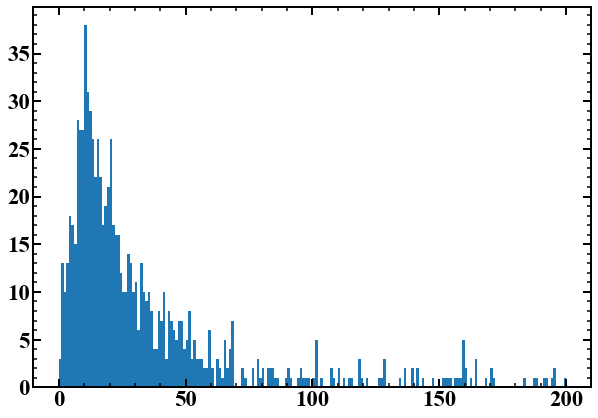

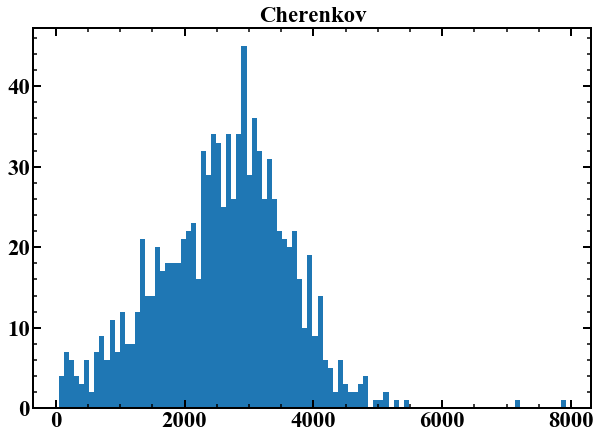

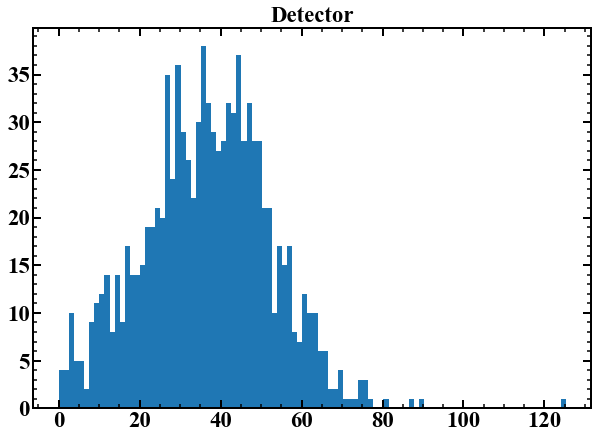

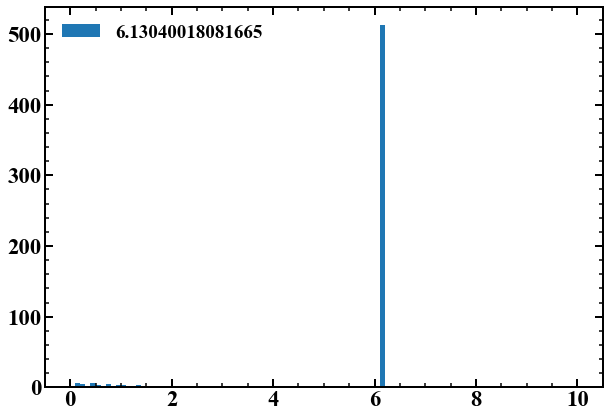

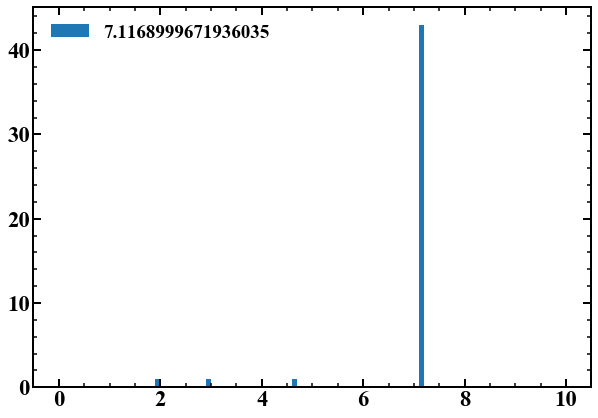

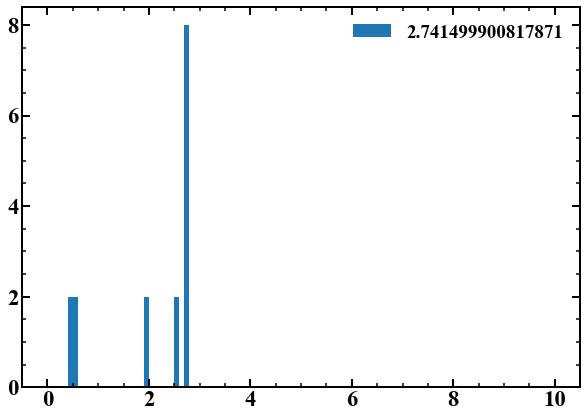

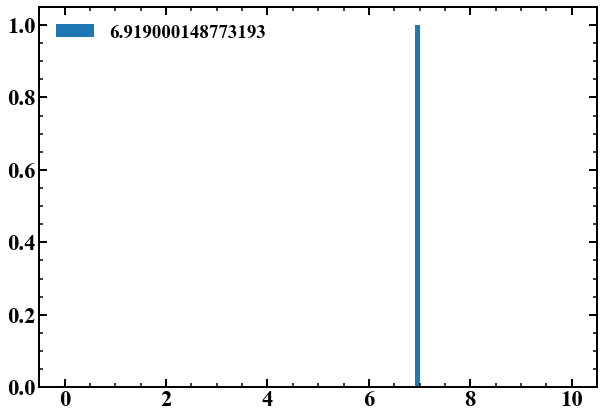

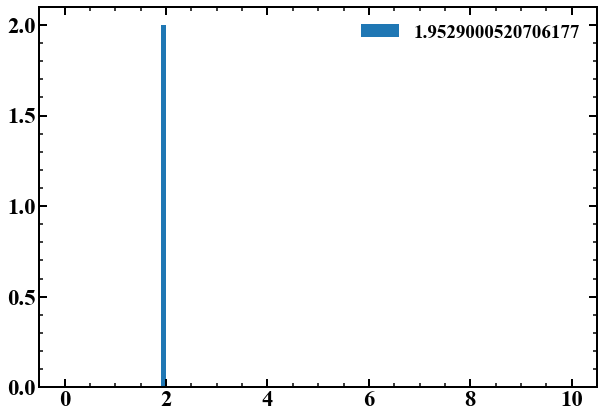

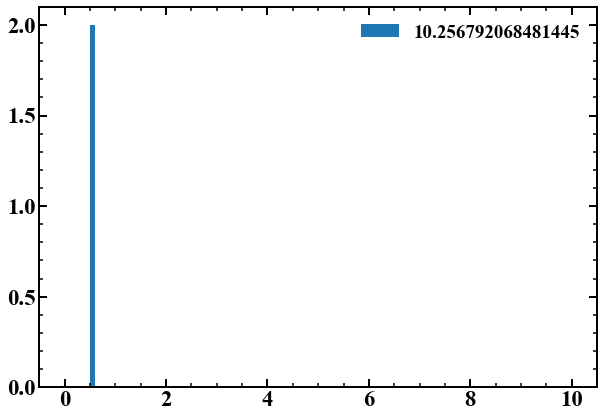

In [70]:
print(volumes)
print(output.keys())

def detectorize_cherenkov(cher, **kwargs):
    qe = kwargs.get('qe', 0.35)
    coverage = kwargs.get('coverage', 0.20)
    effeciency = qe*coverage/5. # Arbitrary 5, scattering?
    val = np.array(cher)*effeciency
    return np.random.normal(val, val**0.5)
    

plt.hist(pe, bins=np.linspace(0,200,201))
plt.show()

plt.title('Cherenkov')
plt.hist(cherenkov, bins=100)
plt.show()

plt.title('Detector')
plt.hist(detectorize_cherenkov(cherenkov), bins=100)
plt.show()

for k,v in output.items():
    plt.hist(v, bins=np.linspace(0,10,101), label=k)
    plt.legend()
    plt.show()